# ARIMA & GARCH Model

## Contents

1. ARIMA

### Notes

**Time Series**: Data collected over fixed time intervals.

**Skewness**: measures asymmetry in the distribution of returns.
  - Skewness = 0 → Symmetric distribution (like the normal distribution).
  - Skewness > 0 → Right-skewed (long tail on the right, mean > median).
    - This means that the majority of the data points cluster around the lower end of the distribution, with fewer data points at higher values. The mean of a right-skewed distribution is typically greater than the median, and the mode (the most frequent value) is usually to the left of the median.
    - **common in stock returns (few extreme positive gains)**.
  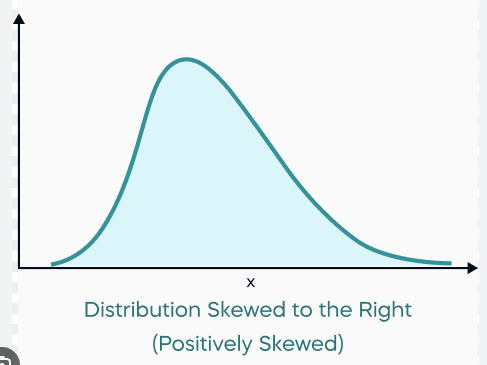
  - Skewness < 0 → Left-skewed (long tail on the left, mean < median).
    - Indicates frequent small gains but rare extreme losses (e.g., crash events)

**Kurtosis**: measures tailedness (fat tails or outliers) compared to a normal distribution.
  - Kurtosis = 3 → Normal distribution (mesokurtic).
  - Kurtosis > 3 → Leptokurtic (fat/heavier/thicker tails, more outliers).
    - **Common in stock returns (extreme events like crashes/booms)**.
  - Kurtosis < 3 → Platykurtic (thin tails, fewer outliers).
  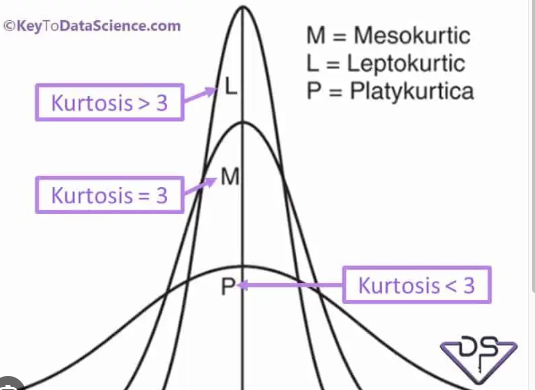


### ARIMA

The *ARIMA model (AutoRegressive Integrated Moving Average)* is a popular statistical method for time series forecasting. It combines three key components to model and predict future values based on past data.

ARIMA is denoted as ARIMA(p, d, q), where:

- p: Autoregressive (AR) term
- d: Differencing (I) term
- q: Moving Average (MA) term


#### Autoregressive Model, AR(p)
- Represent the current value of a time series using its own previous values and a random white noise error, i.e., $X_t=\phi_1 X_{t-1} + \phi_2 X_{t-2}+ \cdot + \phi_p X_{t-p} + \epsilon_t$, denoted as AR(p).
- Use past data to train the coefficient and use them to predict future.
- How to detect Auto-correlation?
  - **PACF Plots** (partial autocorrelation function).
  - X axis are lags, Y axis are partial autocorrelation at lags, i.e., when $X=k$, $Y=ParCorr(X_{t+k},X_t)$. The blue band area is 95% confidence interval.


#### Differencing Model, I(d)

- Makes the time series *stationary* (i.e., removes trends/seasonality)
- Differencing: substract the current value from the previous value. Example: first difference: $y_t^{\prime}=y_t-y_{t-1}$.
- A *trend* represents a long-term increase or decrease in the data. To detect it:
  - Visual inspection (plotting): look for a consistent upward/downward slope; might use rolling mean/median (smoothing) to highlight trends.
  - Statistical tests: **ADF (Augmented Dickey-Fuller) Test**: checks for stationarity.
- *Seasonality* refers to repeating patterns at fixed intervals (e..g, monthly, yearly). To detect it:
  - Visual inspection (plotting): look for repeated peaks/troughs in lag plots or periodic subplots.

#### Moving Average Model, MA(q)

- The current time series value can be represented as a linear combination of current and previous white noise errors.
- Example: an MA(1) model: $y_t=c + \theta_1 \epsilon_{t-1}+\epsilon_t$, where $\theta$ is the coefficient and $\epsilon$ is residual error.
- How to detect if MA exist: use Autocorrelation Plot (ACF)

#### How ARIMA Works:
- Make the series stationary (via differencing, d).
- Fit AR and MA terms to the stationary data.
  - AR captures *memory* of past values.
  - MA captures *shocks* (unexpected change).
- Forecast future values by combining these effects.

#### Steps to Build an ARIMA Model
1. Check Stationary: use tests like **ADF (Augmented Dickey-Fuller)**.
2. Determine d: difference until stationary.
3. Identify p and q: use **ACF (AutoCorrelation Function)** and **PACF (Partial ACF)** Plot.
4. Fit the Model: estimate coefficients.
5. Validate: check residuals (should resemble white noise).



#### Reference:

https://letianzj.github.io/arima-garch-model.html

### ARIMA

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
from datetime import datetime, timedelta
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas_datareader as pdr

#### Download Data

In [3]:
# !pip install yfinance

import yfinance as yf

In [4]:
end_date = datetime.today()
start_date = datetime(2000, 1, 1)
spx = yf.download('^GSPC', start=start_date, end=end_date) # S&P 500 Index

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [5]:
spx.head()

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [6]:
if isinstance(spx.columns, pd.MultiIndex):
    spx.columns = spx.columns.droplevel(1) # drop the 'Ticker' level

In [7]:
spx.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2000-01-03,1455.219971,1478.000000,1438.359985,1469.250000,931800000
2000-01-04,1399.420044,1455.219971,1397.430054,1455.219971,1009000000
2000-01-05,1402.109985,1413.270020,1377.680054,1399.420044,1085500000
2000-01-06,1403.449951,1411.900024,1392.099976,1402.109985,1092300000
2000-01-07,1441.469971,1441.469971,1400.729980,1403.449951,1225200000


In [8]:
hist_close = spx['Close']
hist_return = hist_close / hist_close.shift(1) - 1 # shift forward one day
# hist_return = hist_close.pct_change(1) # same

hist_return.dropna(inplace=True)
hist_return = hist_return * 100.0

In [9]:
hist_return.head()

,Close
Date,
2000-01-04,-3.834467
2000-01-05,0.192218
2000-01-06,0.095568
2000-01-07,2.709040
2000-01-10,1.118997


In [10]:
print(hist_return.describe())

print(f"Skew: {scipy.stats.skew(hist_return)}, Kurtosis: {scipy.stats.kurtosis(hist_return)}")

count    6395.000000
mean        0.029722
std         1.229275
min       -11.984055
25%        -0.479891
50%         0.062258
75%         0.593491
max        11.580037
Name: Close, dtype: float64
Skew: -0.11540199513839566, Kurtosis: 10.361112099636268


Since skewness < 0 (slight left skew), it indicates frequent small gains but rare extreme losses (e.g., crash events).

Since kurtosis > 0 (high kurtosis), it indicates fast tails, higher risk of extreme returns.

#### ARIMA Model - Step One: Identify (p, d, q)

It's known that stock prices are not stationary while return might be.

**ADF Test**:
determine whether a time series has a unit root, indicating that is is **non-stationary**.
- null hypothesis: the time series has a unit root --> it is non-stationary.
- alternative hypothesis: the time serise does not have a unit root --> it is stationary.

In [11]:
from statsmodels.tsa.stattools import adfuller

hist_close_adf = adfuller(hist_close)
hist_return_adf = adfuller(hist_return)

print(f"ADF Statistics for historial stock price: {hist_close_adf[0]}, p-value: {hist_close_adf[1]}") # cannot reject null hypothesis --> non-stationary
print(f"ADF Statistics for historical return: {hist_return_adf[0]}, p-value: {hist_return_adf[1]}") # reject null hypothesis --> stationary

ADF Statistics for historial stock price: 2.1738290111264194, p-value: 0.998860271918362
ADF Statistics for historical return: -19.27552942801097, p-value: 0.0


ADF p-value for historical return series is 0, which rejects the null hypothesis of unit root. Therefore, we accept d=0 in ARIMA(p, d, q), and the next step is to identify lag p and q by using ACF (AutoCorrelation Function) and PACF (Partial ACF) Plot.

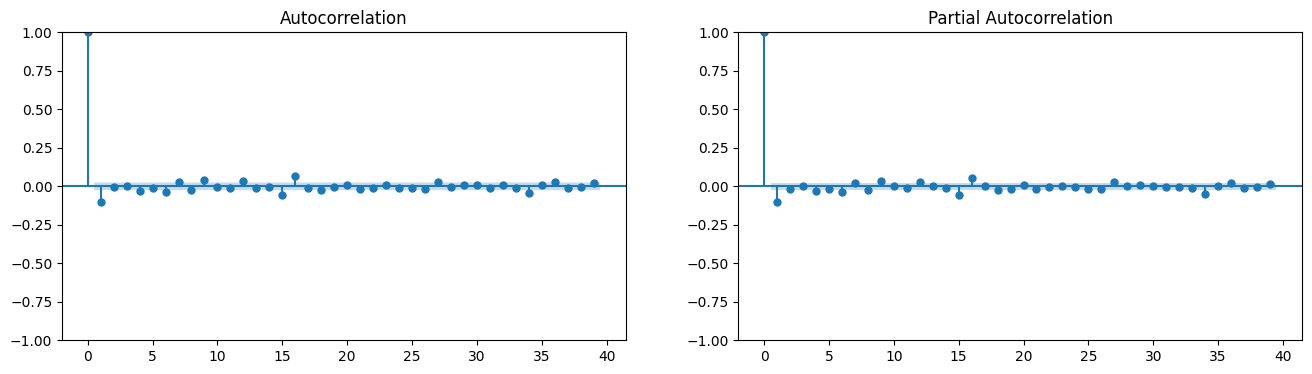

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(16, 4))
plot_acf(hist_return, ax=axes[0])  # determines MA(q)
plot_pacf(hist_return, ax=axes[1]) # determines AR(p)
plt.show()

In [13]:
act_stats = acf(hist_return, fft=False)[1:40]
acf_df = pd.DataFrame([act_stats]).T
acf_df.columns = ['acf']
acf_df.index += 1

pacf_stats = pacf(hist_return)[1:40]
pacf_df = pd.DataFrame([pacf_stats]).T
pacf_df.columns = ['pacf']
pacf_df.index += 1

acf_pacf_df = pd.concat([acf_df, pacf_df], axis=1)
acf_pacf_df.head()

,acf,pacf
1,-0.101558,-0.101574
2,-0.006916,-0.017415
3,0.002279,-0.000206
4,-0.029936,-0.030181
5,-0.014224,-0.020616


The ACF and PACF plots suggest a lag up to 35 business days, which makes the model practically unusable. Here we constraint max lag to 5 days to use AIC to select the best model.

**AIC (Akaike Information Criterion)** is a statistical metric used to evaluate the quality of a model relative to other models. It balances model fit and model complexity.

- The formula is: $AIC=2k-2ln(L)$, wher $k=$ number of parameters in the model (complexity), $L=$ the maximum likelihood of the model (fit).

- The goal is to find a model that fits well without overfitting.
- A model with too few parameters may underfit (bad fit, low likelihood).
- A model with too many parameters may overfit (high likelihood but too complex).
- AIC penalizes complexity: even if a model fits better, if it uses many parameters, AIC might still be higher.

In [14]:
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

hist_training = hist_return[:-45]
hist_testing = hist_return[-45:]

dict_aic = {}
for p in range(6):
  for q in range(6):
    try:
      model = ARIMA(hist_training, order=(p, 0, q))
      model_fit = model.fit()
      dict_aic[(p, q)] = model_fit.aic
    except:
      pass

aic_df = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
p, q = aic_df[aic_df.aic == aic_df.aic.min()].index[0]
print(f"Best ARIMA order (p,0,q) is ({p}, {0}, {q}) with AIC: {aic_df.aic.min()}")

Best ARIMA order (p,0,q) is (4, 0, 5) with AIC: 20453.723940178003


#### ARIMA Model - Step Two: Fit the Model

In [15]:
# Train the selected model
model = ARIMA(hist_training, order=(p, 0, q))
arima_fitted = model.fit()
arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 6350
Model:                 ARIMA(4, 0, 5)   Log Likelihood              -10215.862
Date:                Sat, 07 Jun 2025   AIC                          20453.724
Time:                        01:10:11   BIC                          20528.042
Sample:                             0   HQIC                         20479.459
                               - 6350                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0290      0.014      2.067      0.039       0.002       0.056
ar.L1         -0.5247      0.103     -5.112      0.000      -0.726      -0.324
ar.L2          0.8191      0.112      7.298      0.000       0.599       1.039
ar.L3         -0.0426      0.106     -0.402      0.688      -0.250       0.165
ar.L4         -0.6255      0.087     -7.214      0.000      -0.795      -0.456
ma.L1          0.4232      0.104      4.077      0.000       0.220       0.627
ma.L2         -0.8827      0.106     -8.333      0.000      -1.090      -0.675
ma.L3          0.1314      0.111      1.186      0.236      -0.086       0.348
ma.L4          0.5862      0.081      7.222      0.000       0.427       0.745
ma.L5         -0.0954      0.011     -8.959      0.000      -0.116      -0.075
sigma2         1.4622      0.012    122.434      0.000       1.439       1.486
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21804.21
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.01   Skew:                            -0.37
Prob(H) (two-sided):                  0.86   Kurtosis:                        12.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### ARIMA Model - Step Three: Residual Analysis

In ARIMA modeling, we assume that residuals (errors) are normally distributed, independent, and have constant variance. If residuals deviate significantly from normality, the model might not be well-specified.

- Plot residual distribution (Kernel Density Estimate):
  - check if residuals folow a normal distribution (should be in a well-fitted ARIMA model)

- QQ Plot (Quantile-Quantile Plot)
  - line='s' means a 45 degree reference line ("standardized")
  - if residuals fall on the line, they're normally distributed

- D’Agostino and Pearson’s test
  - normaltest() checks if a sample differs from a normal distribution by combining skewness and kurtosis.
  - Null Hypothesis: data comes from a normal distribution.
  - if p value < 0.05, reject null hypothesis --> data not normally distributed.

- Shapiro-Wilk test
  - shapiro() directly tests for normality (especially good for small sample sizes, n<5000).
  - Null Hypothesis: data comes from a normal distribution.
  - if p value < 0.05, reject null hypothesis --> data not normally distributed.

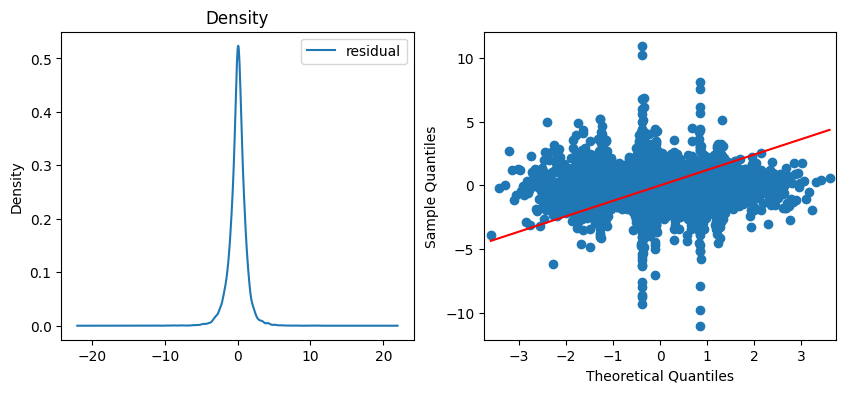

In [16]:
residuals = pd.DataFrame(arima_fitted.resid, columns=['residual'])
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[0])
sm.qqplot(residuals, line='s', ax=ax[1]) #
plt.show()

In [17]:
# Normality test
from scipy.stats import shapiro, normaltest
stat, p = normaltest(residuals)
print(f"Statistics={stat[0]:.3f}, p={p[0]:.3f}") # H0: Gaussian
stat, p = shapiro(residuals)
print(f"Statistics={stat:.3f}, p={p:.3f}") # H0: Gaussian

Statistics=1190.482, p=0.000
Statistics=0.909, p=0.000


The residuals do not pass the normality tests. This is somehow expected. Because we limit the lag orders; there still has remaining autocorrelation.

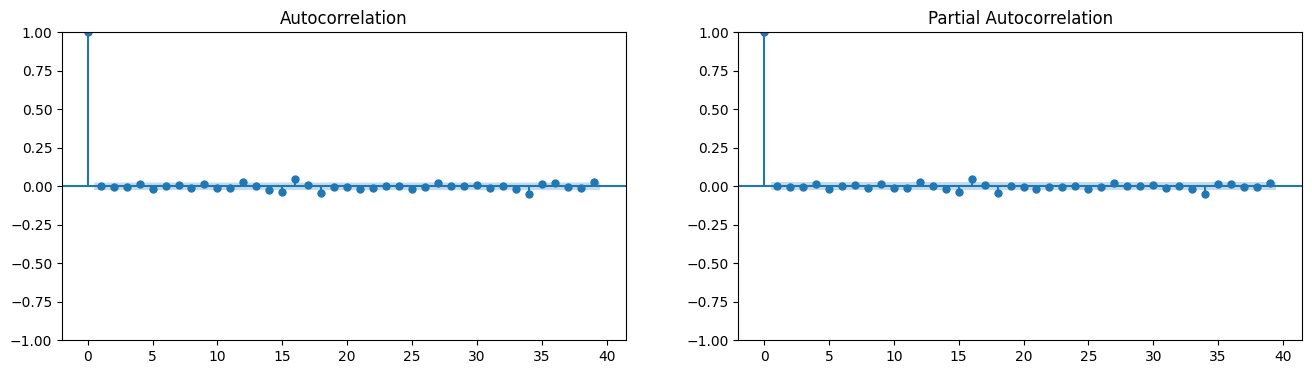

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals, ax=axes[0])
plot_pacf(residuals, ax=axes[1])
plt.show()

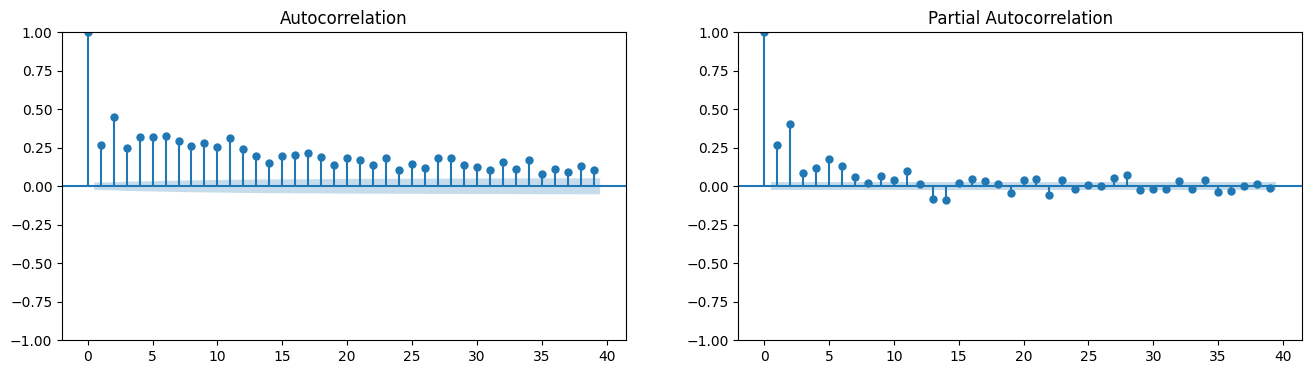

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(residuals**2, ax=axes[0])
plot_pacf(residuals**2, ax=axes[1])
plt.show()

In addition, There exists autocorrelation in squared residuals, suggesting GARCH.

Nevertheless, let's use the model to forecast to see how it goes.

#### ARIMA Model - Step Four: Forecast

In [27]:
print(hist_training.shape)
print(hist_testing.shape)

(6350,)
(45,)


In [40]:
forecast_result = arima_fitted.get_forecast(steps=hist_testing.shape[0])

forecasted = forecast_result.predicted_mean
forecasted_std = forecast_result.se_mean # standard error
forecasted_bounds = forecast_result.conf_int() # confidence intervals

In [46]:
forecasted.head(2)

,predicted_mean
6350,0.024257
6351,0.084539


In [47]:
forecasted_std.head(2)

,var_pred_mean
6350,1.209227
6351,1.215439


In [48]:
forecasted_bounds.head(2)

,lower Close,upper Close
6350,-2.345785,2.394299
6351,-2.297677,2.466756


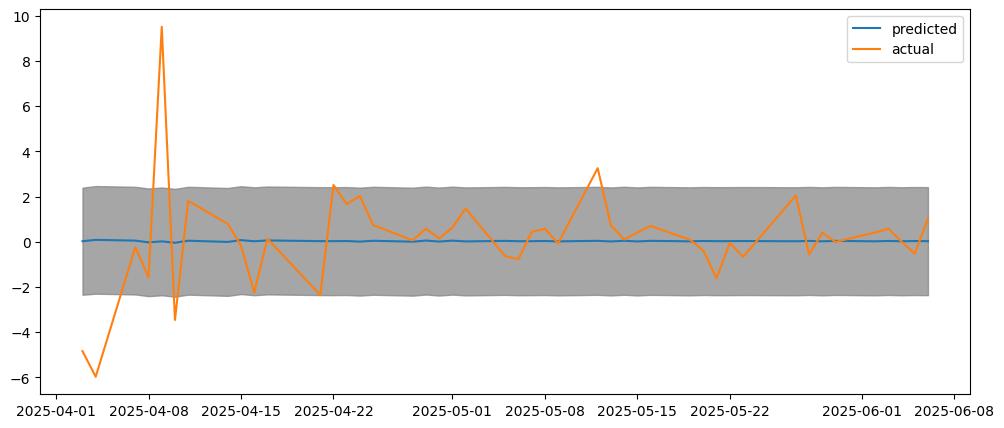

In [58]:
plt.figure(figsize=(12, 5))
return_predicted = pd.DataFrame(forecasted.values, index=hist_testing.index)
return_lb = pd.DataFrame(forecasted_bounds['lower Close'].values, index=hist_testing.index)
return_ub = pd.DataFrame(forecasted_bounds['upper Close'].values, index=hist_testing.index)
plt.plot(return_predicted, label='predicted')
plt.plot(hist_testing, label='actual')
plt.fill_between(hist_testing.index, return_lb.values.reshape([-1]), return_ub.values.reshape([-1]), color='grey', alpha=0.7)
plt.legend()
plt.show()

The return forecast is centered around 0%, with 95% confidence bands. The forecast results are not good.
It is shown in the plot that the historical return undergoing a turbulent stage, even slumped 6% at the beginning and then jumpped 10% during the forecast time window.

### GARCH

GARCH (Generalized Autoregressive Conditional Heteroskedasticity) is a time series model used to model and forecast volatility, especially in financial return series.

While ARIMA models the mean of a time series, GARCH models the variance — particularly when the variance changes over time (i.e., it’s heteroskedastic).

A GARCH(p, q) model consists of:
- An equation for the return (could be just a constant or include an ARMA model)
- An equation for the conditional variance )

Variance Equation:
$\sigma_t^2=w+\Sigma_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \Sigma_{j=1}^p \beta_j \sigma_{t-j}^2$,
where
- $\sigma_t^2$: the forecasted volatility at time t; conditional variance
- $w$: constant term; long-run average variance
- $\epsilon_{t-i}^2$: past squared residuals (from the return equation)
- $\sigma_{t-j}^2$: past variances
- $\alpha_i$: coefficients for the past shocks (ARCH terms)
- $\beta_j$: coefficients for the past variances (GARCH terms)
- $q$: order of ARCH terms
- $p$: order of GARCH terms

Intuition:

The variance today depends on (1) Past shocks (ARCH part); (2) Past variances (GARCH part).
- ARCH effect ($\alpha$): measures how past shocsk (unexpected price changes) affect current volatility.
  - high $\alpha$ means volatility reacts strongly to market shocks.
  - large residuals → large future variance (volatility reacts to past shocks).
- GARCH effect ($\beta$): measures persistence in volatility.
  - high $\beta$ means volatility is slow to decay (long memory).
  - past volatility affects future volatility.
- stability condition: $\alpha + \beta < 1$ (ensures volatility doesn't explode).


GARCH vs. ARCH
- ARCH(q): uses only past squared errors.
- GARCH(p, q): includes past variances too → more flexible and realistic.




#### AR-GARCH Step One: Identify Orders

- $l$: autoregressive (AR) lags in the mean model (AR(l)).
- $p$: GARCH order (lagged variance terms).
- $q$: ARCH order (lagged squared residual terms).

Constrain both the AR lag and CARCH lag be less than 5 here. Select the combination $(l, p, q)$ with the lowest AIC.

In [60]:
# !pip install arch

In [74]:
from arch import arch_model
dict_aic = {}

for l in range(5):
  for p in range(1, 5):
    for q in range(1, 5):
      try:
        split_date = hist_return.index[-45]
        model = arch_model(
            hist_return,
            mean='ARX',   # mean model: AR(l) with exogenous terms (if any)
            lags=l,       # AR order
            vol='Garch',  # volatility model: GARCH(p, q)
            p=p,          # GARCH order
            o=0,          # no asymmetry (e.g., no TARCH/EGARCH)
            q=q,          # ARCH order
            dist='Normal' # assume normal distribution for residuals
        )
        res = model.fit(last_obs=split_date) # fit up to 'split_date'
        dict_aic[(l, p, q)] = res.aic
      except:
        pass

df_aic = pd.DataFrame.from_dict(dict_aic, orient='index', columns=['aic'])
l, p, q = df_aic[df_aic['aic'] == df_aic['aic'].min()].index[0]
print(f"ARIMA-GARCH order is ({l}, {p}, {q})")

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3772636803.4754105
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3517038674.919114
Iteration:      3,   Func. Count:     22,   Neg. LLF: 12241.934037904415
Iteration:      4,   Func. Count:     29,   Neg. LLF: 8970.669038006234
Iteration:      5,   Func. Count:     35,   Neg. LLF: 8818.714694237657
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8752.180155896258
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8861.484666136754
Iteration:      8,   Func. Count:     53,   Neg. LLF: 8738.013823381767
Iteration:      9,   Func. Count:     58,   Neg. LLF: 8738.00483285723
Iteration:     10,   Func. Count:     63,   Neg. LLF: 8738.004540395474
Iteration:     11,   Func. Count:     68,   Neg. LLF: 8738.00451870553
Iteration:     12,   Func. Count:     73,   Neg. LLF: 8738.004518191628
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8738.004518191628
            Iterations: 12
 

#### AR-GARCH Model Step Two: Fit the Model

In [76]:
print(l, p, q)

4 2 2


In [77]:
model = arch_model(
    hist_return,
    mean='ARX',
    lags=l,
    vol='Garch',
    p=p,
    o=0,
    q=q,
    dist='Normal'
)
res = model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:     12,   Neg. LLF: 281075.90839033417
Iteration:      2,   Func. Count:     29,   Neg. LLF: 56041.99669700164
Iteration:      3,   Func. Count:     44,   Neg. LLF: 40945.17134172003
Iteration:      4,   Func. Count:     59,   Neg. LLF: 65988.93018117192
Iteration:      5,   Func. Count:     73,   Neg. LLF: 49343.12414835348
Iteration:      6,   Func. Count:     87,   Neg. LLF: 32774.19497869884
Iteration:      7,   Func. Count:    101,   Neg. LLF: 11942.784404121769
Iteration:      8,   Func. Count:    115,   Neg. LLF: 9496.15896368957
Iteration:      9,   Func. Count:    128,   Neg. LLF: 9234.61960986879
Iteration:     10,   Func. Count:    140,   Neg. LLF: 8879.483915988389
Iteration:     11,   Func. Count:    152,   Neg. LLF: 8713.154825120884
Iteration:     12,   Func. Count:    164,   Neg. LLF: 8715.26857578084
Iteration:     13,   Func. Count:    176,   Neg. LLF: 8710.832642602281
Iteration:     14,   Func. Count:    188,   Neg. LLF: 8709.248233

In [78]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.007
Mean Model:                        AR   Adj. R-squared:                  0.006
Vol Model:                      GARCH   Log-Likelihood:               -8709.25
Distribution:                  Normal   AIC:                           17438.5
Method:            Maximum Likelihood   BIC:                           17506.1
                                        No. Observations:                 6346
Date:                Sat, Jun 07 2025   Df Residuals:                     6341
Time:                        02:47:39   Df Model:                            5
                                  Mean Model                                  
==============================================================================
                 coef    std err          t      P>|t|        95.0% Conf. Int.
------------------------------------------------------------------------------
Const          0.0733  1.087e-02      6.745  1.527e-11   [5.202e-02,9.463e-02]
Close[1]      -0.0541  1.315e-02     -4.112  3.924e-05 [-7.984e-02,-2.830e-02]
Close[2]      -0.0268  1.394e-02     -1.922  5.460e-02  [-5.410e-02,5.287e-04]
Close[3]      -0.0205  1.346e-02     -1.526      0.127  [-4.692e-02,5.840e-03]
Close[4]      -0.0140  1.397e-02     -1.002      0.316  [-4.138e-02,1.338e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0421  9.401e-03      4.476  7.590e-06 [2.366e-02,6.051e-02]
alpha[1]       0.0828  2.319e-02      3.572  3.549e-04   [3.738e-02,  0.128]
alpha[2]       0.1266  2.401e-02      5.276  1.321e-07   [7.960e-02,  0.174]
beta[1]        0.2067      0.322      0.641      0.521     [ -0.425,  0.838]
beta[2]        0.5523      0.290      1.907  5.649e-02  [-1.528e-02,  1.120]
============================================================================

Covariance estimator: robust
"""

From the model fit results, we know that only Const and Close[1] are statistically significiant (p < 0.05). Close[2] is borderline.
We might consider simplifying the mean model to AR(1) or AR(2) (removing lags 3 and 4).

ARCH terms (alpha[1], alpha[2]) are highly significant, indicating strong short-term volatility clustering.
GARCH terms (beta[1], beta[2]) are not significant, suggesting weak persistence in long-term volatility.
We might try a pure ARCH(2) (removing GARCH terms).

R² = 0.007: The mean model explains very little variance (expected for financial returns).

In [84]:
# # Refit as AR(1) or AR(2) (removing insignificant lags 3 and 4)
# model2 = arch_model(hist_return, mean='AR', lags=1, vol='Garch', p=2, q=2)
# res2 = model2.fit(last_obs=split_date)
# res2.summary()

In [83]:
# # Simplify the volatility model (GARCH(1, 2))
# model3 = arch_model(hist_return, mean='AR', lags=1, vol='Garch', p=1, q=2)
# res3 = model3.fit(last_obs=split_date)
# res3.summary()

#### AR-GARCH Model Step Three: Evaluate Model via Residuals

- standardized residuals: residuals scaled by their estimated volatility.
- if the model fits well, the standardized residuals should behave like i.i.d. standard normal (mean=0, variance=1).

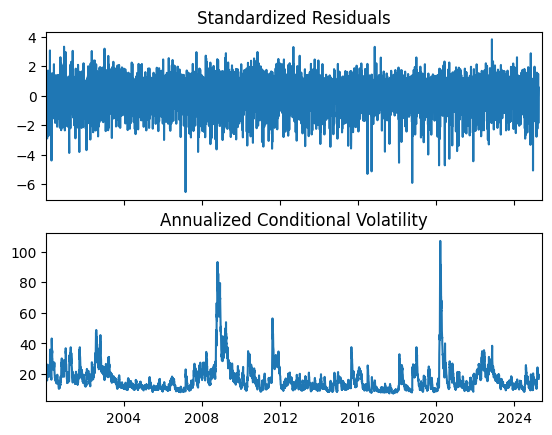

In [100]:
res.plot(annualize='D') # convert volatility to annualized units
std_resid = res.resid /res.conditional_volatility # standardized residuals (residuals scaled by their estimated volatility)
std_resid.dropna(inplace=True)

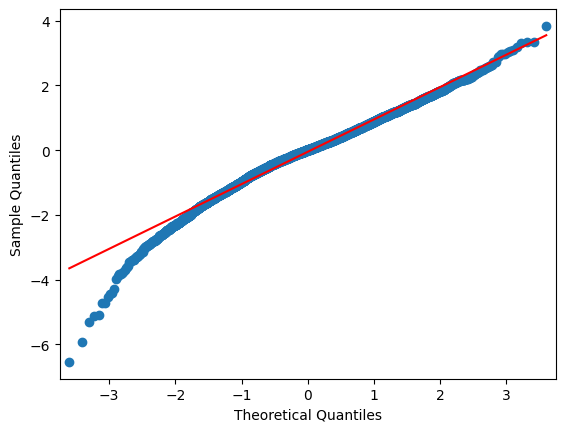

In [102]:
sm.qqplot(std_resid, line='s');

In [103]:
stat, p = normaltest(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian
stat, p = shapiro(std_resid)
print(f'Statistics={stat:.3f}, p={p:.3f}')       # H0: Gaussian

Statistics=471.574, p=0.000
Statistics=0.982, p=0.000


Since p value < 0.05, reject null hypothesis --> standardized residuals are not normally distributed.

#### AR-GARCH Model Step Four: Forecast

In [104]:
forecasts = res.forecast(horizon=1, start=split_date)

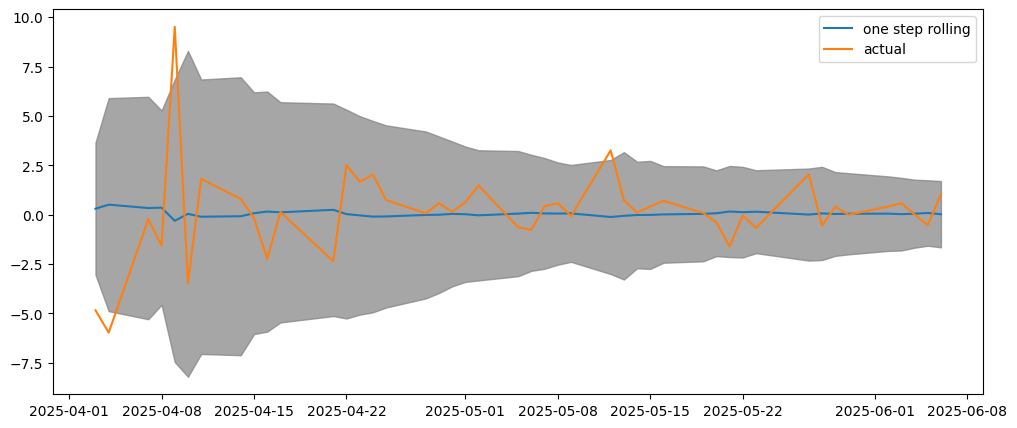

In [106]:
conf = np.sqrt(forecasts.variance[split_date:])*1.96

plt.figure(figsize=(12, 5))
plt.plot(forecasts.mean[split_date:], label='one step rolling')
plt.plot(hist_return[split_date:], label='actual')
plt.fill_between(hist_return[split_date:].index, (forecasts.mean[split_date:]-conf).values.reshape(-1), (forecasts.mean[split_date:]+conf).values.reshape(-1), color='gray', alpha=0.7)
plt.legend()
plt.show()